In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output

In [3]:
style.use('ggplot')

In [4]:
conn = MongoClient('120.126.136.17')
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))
    
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

df = df[(df['hr_value'] != 0)]
# map out the weekday
df['weekday'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%w'))
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1]
          - (datetime.datetime.fromtimestamp(x).isoweekday() < 7)) # do this so that week may start on sunday

In [5]:
dfsteptotal = pd.DataFrame()
dfsteptotal = df[['week', 'weekday']].set_index(['week', 'weekday'])
dfsteptotal = dfsteptotal[~dfsteptotal.index.duplicated(keep='first')]
dfsteptotal['steps'] = 0
dfsteptotal.reset_index(inplace=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['5'], 'steps':[0]})
dfsteptotal = dfsteptotal.append(dfadd, ignore_index=True)
dfsteptotal = dfsteptotal.set_index(['week', 'weekday'])
dfsteptotal.sort_index(inplace=True)

In [6]:
# here I map between integer and the sting it's mean
timeslidemap = {0:'morning', 1:'afternoon', 2:'evening'}
basestamp = df['timestamp'][0]
endstamp = df['timestamp'][-1:].values[0]
# for num, row in df[:30000].iterrows():
while True:
    try:
        dfbetween = df.loc[df['timestamp'].between(
            datetime.datetime.fromtimestamp(basestamp).replace(hour=0,minute=0,second=0).timestamp(),
            datetime.datetime.fromtimestamp(basestamp).replace(hour=23,minute=59,second=59).timestamp()
                    , inclusive=True)]
        steps = dfbetween['step_value'].sum()
    #     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
    #             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
    #                 timeslidemap[estimedevide])

        dfsteptotal.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
                                    (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
                            datetime.datetime.fromtimestamp(basestamp).strftime('%w'))], 
                                           ['steps']] += steps

        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(days=1)).timestamp()
        if basestamp > endstamp:
            break
    except Exception as e:
        print(str(e))
        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(days=1)).timestamp()
#     else:
#         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))

In [7]:
dfsteptotal.loc[(12,'5')] = dfsteptotal.xs('5', level=1).sum() / (dfsteptotal.xs('5', level=1).count() - 1)
dfsteptotal['Comfort'] = 0
dfsteptotal['Precp'] = 0

In [8]:
# add wether 
coding = 'utf-8'
table = pd.DataFrame()
basetime = datetime.date(2019,3,27)
num = 0
for index, row in dfsteptotal.iterrows():
    try:
        # parsing part
        date = basetime + datetime.timedelta(days = num)
        print(date)
        num += 1
        dateStr = date.strftime('%Y-%m-%d')
        url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=C0AC60'+ \
            '&stname=%25E4%25B8%2589%25E5%25B3%25BD&datepicker=' + dateStr
        table = pd.read_html(url,encoding=coding,index_col=0,header=None,flavor='bs4')[1]
        # start dataprocess
        table.replace('/', np.nan, inplace=True)
        table.replace('X', np.nan, inplace=True)  
        table.fillna(method='ffill', inplace=True)
        table.index -= 1
        dfoneday = pd.DataFrame()
        # the table data need to reshape and turn to a variable
        T = table['temperature'].values.reshape(len(table['temperature'].values)).astype('float')
        RH = table['RH'].values.reshape(len(table['RH'].values)).astype('float')
        dfoneday['comfort'] = T - 0.55 *(1-RH/100)*(T - 14)
        dfoneday['Precp'] = table['Precp']['降水量(mm)']
        bins = [0,11,16,20,27,31,60]
        labels=[0,1,2,3,4,5]
        dfoneday['bins'] = pd.cut(dfoneday['comfort'], bins=bins, labels=labels, include_lowest=True)
        # mComfort aComfort eComfort mPrecp aPrecp ePrecp
        dfsteptotal.loc[[index], ['Comfort']] = dfoneday['bins'].astype(int).mean()
        dfoneday['Precp'].astype(float)
        dfsteptotal.loc[[index], ['Precp']] = dfoneday['Precp'].astype(float).sum()
    except Exception as e:
        if str(e) == "could not convert string to float: '...'":
            print('some data are not yet ready')
            break

2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02
2019-04-03
2019-04-04
2019-04-05
2019-04-06
2019-04-07
2019-04-08
2019-04-09
2019-04-10
2019-04-11
2019-04-12
2019-04-13
2019-04-14
2019-04-15
2019-04-16
2019-04-17
2019-04-18
2019-04-19
2019-04-20
2019-04-21
2019-04-22
2019-04-23
2019-04-24
some data are not yet ready


In [34]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences[0])):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences[0])-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[0][i:end_ix].reshape(len(sequences[0][i:end_ix]),1) 
        seq_x = np.append(seq_x, sequences[1][i:end_ix].reshape(len(sequences[1][i:end_ix]),1), axis=1)
        seq_x = np.append(seq_x, sequences[2][i:end_ix].reshape(len(sequences[2][i:end_ix]),1), axis=1)
        seq_y1 =  sequences[0][end_ix]
        X.append(seq_x)
        y.append(seq_y1)
    return np.array(X), np.array(y)

In [63]:
steps = dfsteptotal['steps'][:-1].values
Comfort = dfsteptotal['Comfort'][:-1].values
Precp = dfsteptotal['Precp'][:-1].values

scaler = preprocessing.StandardScaler()
dataset = np.array([steps, Comfort, Precp])

scaler = preprocessing.StandardScaler()
dataset = np.array([steps, Comfort, Precp])
normalized_dataset = scaler.fit_transform(dataset)
n_steps = 3
X, y = split_sequences(normalized_dataset, n_steps)

In [64]:
n_features = 3
model = Sequential()
model.add(keras.layers.LSTM(100,activation='relu', return_sequences=True,input_shape=(n_steps, n_features)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(50 ,activation='relu'))
model.add(keras.layers.LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 3, 100)            41600     
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 122,101
Trainable params: 122,101
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(X, y, epochs=100, verbose=0, batch_size=128, validation_split=0.2)

<IPython.core.display.Javascript object>


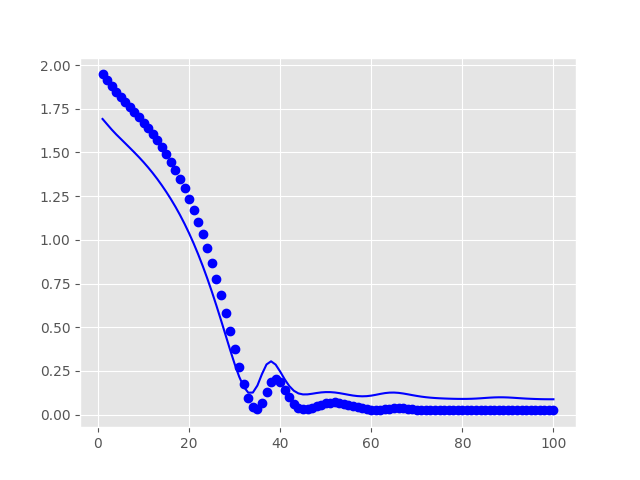

In [66]:
%matplotlib notebook
loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [ ]:
model.predict([])

In [62]:
scaler.inverse_transform

In [44]:
scaler.inverse_transform(normalized_dataset)

array([[ 2.36600000e+03,  2.10400000e+03,  5.33600000e+03,
         3.09300000e+03,  1.14100000e+03,  1.04320000e+04,
         6.94000000e+03,  5.91900000e+03,  5.47900000e+03,
         4.19200000e+03,  5.14300000e+03,  8.83700000e+03,
         5.70700000e+03,  4.13200000e+03,  5.91100000e+03,
         2.84700000e+03,  5.63500000e+03,  6.11700000e+03,
         8.26400000e+03,  1.37470000e+04,  5.92700000e+03,
         7.31300000e+03,  9.57700000e+03,  6.18200000e+03,
         7.80800000e+03,  5.81500000e+03,  1.15150000e+04,
         7.37600000e+03],
       [ 2.66666667e+00,  2.87500000e+00,  2.91666667e+00,
         2.58333333e+00,  2.00000000e+00,  1.70833333e+00,
         2.29166667e+00,  2.41666667e+00,  2.87500000e+00,
        -3.84307168e+17,  2.70833333e+00,  2.83333333e+00,
         3.00000000e+00,  3.04166667e+00,  3.00000000e+00,
         2.62500000e+00,  2.08333333e+00,  2.70833333e+00,
         2.83333333e+00,  2.08333333e+00,  2.00000000e+00,
         2.54166667e+00,  2.75